In [16]:
from __future__ import print_function
import os
import sys
import pandas as pd
from collections import namedtuple
from collections import OrderedDict
from functools import reduce
sys.path.insert(0, os.path.abspath('/Users/pango/Projs/Quant/abu-master/'))

In [17]:
from collections import namedtuple
from collections import OrderedDict

class StockTradeDays(object):
    def __init__(self, price_array, start_date, date_array=None):
        # 私有价格序列
        self.__price_array = price_array
        # 私有日期序列
        self.__date_array = self._init_days(start_date, date_array)
        # 私有涨跌幅序列
        self.__change_array = self.__init_change()
        # 进行OrderedDict的组装
        self.stock_dict = self._init_stock_dict()

    def __init_change(self):
        """
        从price_array生成change_array
        :return:
        """
        price_float_array = [float(price_str) for price_str in
                             self.__price_array]
        # 通过将时间平移形成两个错开的收盘价序列，通过zip打包成为一个新的序列
        # 每个元素为相邻的两个收盘价格
        pp_array = [(price1, price2) for price1, price2 in
                    zip(price_float_array[:-1], price_float_array[1:])]
        change_array = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), pp_array))
        # list insert插入数据，将第一天的涨跌幅设置为0
        change_array.insert(0, 0)
        return change_array

    def _init_days(self, start_date, date_array):
        """
        protect方法，
        :param start_date: 初始日期
        :param date_array: 给定日期序列
        :return:
        """
        if date_array is None:
            # 由start_date和self.__price_array来确定日期序列
            date_array = [str(start_date + ind) for ind, _ in
                          enumerate(self.__price_array)]
        else:
            # 稍后的内容会使用外部直接设置的方式
            # 如果外面设置了date_array，就直接转换str类型组成新date_array
            date_array = [str(date) for date in date_array]
        return date_array

    def _init_stock_dict(self):
        """
        使用namedtuple，OrderedDict将结果合并
        :return:
        """
        stock_namedtuple = namedtuple('stock',
                                      ('date', 'price', 'change'))

        # 使用以被赋值的__date_array等进行OrderedDict的组装
        stock_dict = OrderedDict(
            (date, stock_namedtuple(date, price, change))
            for date, price, change in
            zip(self.__date_array, self.__price_array,
                self.__change_array))
        return stock_dict

    def filter_stock(self, want_up=True, want_calc_sum=False):
        """
        筛选结果子集
        :param want_up: 是否筛选上涨
        :param want_calc_sum: 是否计算涨跌和
        :return:
        """
        # Python中的三目表达式的写法
        filter_func = (lambda p_day: p_day.change > 0) if want_up else (
            lambda p_day: p_day.change < 0)
        # 使用filter_func做筛选函数
        want_days = list(filter(filter_func, self.stock_dict.values()))

        if not want_calc_sum:
            return want_days

        # 需要计算涨跌幅和
        change_sum = 0.0
        for day in want_days:
            change_sum += day.change
        return change_sum

    """
        下面的__str__，__iter__， __getitem__， __len__稍后会详细讲解作
    """

    def __str__(self):
        return str(self.stock_dict)

    __repr__ = __str__

    def __iter__(self):
        """
        通过代理stock_dict的跌倒，yield元素
        :return:
        """
        for key in self.stock_dict:
            yield self.stock_dict[key]

    def __getitem__(self, ind):
        date_key = self.__date_array[ind]
        return self.stock_dict[date_key]

    def __len__(self):
        return len(self.stock_dict)

In [18]:
pd.set_option('expand_frame_repr', False)

setup_date = '2020-01-01'
df = pd.read_csv(r'/Users/pango/Projs/Quant/xbx_stock_2019_0420/data/basic-trading-data/full_data/sz300750.csv',

                 )
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['date'], ascending=1, inplace=True)

df_period = df[df['date'] > setup_date]
price_array = df_period['close'].to_list()
date_array_period = df_period['date']
change_array = df_period['change'].to_list()

date_dateframe = (df_period['date'].dt.date).to_list()
date_array = [x.strftime('%F') for x in date_dateframe]

In [19]:
date_base = 20200101
trade_days = StockTradeDays(price_array, date_base, date_array) 
print('trade_days对象长度为: {}'.format(len(trade_days)))
print('最后一天交易数据为：{}'.format(trade_days[-1]))

trade_days对象长度为: 271
最后一天交易数据为：stock(date='2021-02-10', price=412.66, change=0.006)


In [20]:
import six
from abc import ABCMeta, abstractmethod
class TradeStrategyBase(six.with_metaclass(ABCMeta, object)):
    '''
    交易策略抽象基类    
    '''
    @abstractmethod
    def buy_strategy(self, *args, **kwargs):
        #买入策略基类
        pass
    @abstractmethod
    def sell_strategy(self, *args, **kwargs):
        #卖出策略基类
        pass

In [21]:
import six
from abc import ABCMeta, abstractmethod


class TradeStrategyBase(six.with_metaclass(ABCMeta, object)):
    """
        交易策略抽象基类
    """

    @abstractmethod
    def buy_strategy(self, *args, **kwargs):
        # 买入策略基类
        pass

    @abstractmethod
    def sell_strategy(self, *args, **kwargs):
        # 卖出策略基类
        pass

class TradeStrategy1(TradeStrategyBase):
    """
        交易策略1: 追涨策略，当股价上涨一个阀值默认为7%时
        买入股票并持有s_keep_stock_threshold（20）天
    """
    s_keep_stock_threshold = 20

    def __init__(self):
        self.keep_stock_day = 0
        # 7%上涨幅度作为买入策略阀值
        self.__buy_change_threshold = 0.07

    def buy_strategy(self, trade_ind, trade_day, trade_days):
        if self.keep_stock_day == 0 and \
                        trade_day.change > self.__buy_change_threshold:

            # 当没有持有股票的时候self.keep_stock_day == 0 并且
            # 符合买入条件上涨一个阀值，买入
            self.keep_stock_day += 1
        elif self.keep_stock_day > 0:
            # self.keep_stock_day > 0代表持有股票，持有股票天数递增
            self.keep_stock_day += 1

    def sell_strategy(self, trade_ind, trade_day, trade_days):
        if self.keep_stock_day >= \
                TradeStrategy1.s_keep_stock_threshold:
            # 当持有股票天数超过阀值s_keep_stock_threshold，卖出股票
            self.keep_stock_day = 0

    """
        property属性稍后会讲到
    """
    @property
    def buy_change_threshold(self):
        return self.__buy_change_threshold

    @buy_change_threshold.setter
    def buy_change_threshold(self, buy_change_threshold):
        if not isinstance(buy_change_threshold, float):
            """
                上涨阀值需要为float类型
            """
            raise TypeError('buy_change_threshold must be float!')
        # 上涨阀值只取小数点后两位
        self.__buy_change_threshold = round(buy_change_threshold, 2)

In [22]:
class TradeLoopBack(object):
    """
        交易回测系统
    """

    def __init__(self, trade_days, trade_strategy):
        """
        使用上一节封装的StockTradeDays类和本节编写的交易策略类
        TradeStrategyBase类初始化交易系统
        :param trade_days: StockTradeDays交易数据序列
        :param trade_strategy: TradeStrategyBase交易策略
        """
        self.trade_days = trade_days
        self.trade_strategy = trade_strategy
        # 交易盈亏结果序列
        self.profit_array = []

    def execute_trade(self):
        """
        执行交易回测
        :return:
        """
        for ind, day in enumerate(self.trade_days):
            """
                以时间驱动，完成交易回测
            """
            if self.trade_strategy.keep_stock_day > 0:
                # 如果有持有股票，加入交易盈亏结果序列
                self.profit_array.append(day.change)

            # hasattr: 用来查询对象有没有实现某个方法
            if hasattr(self.trade_strategy, 'buy_strategy'):
                # 买入策略执行
                self.trade_strategy.buy_strategy(ind, day,
                                                 self.trade_days)
                
            if hasattr(self.trade_strategy, 'sell_strategy'):
                # 卖出策略执行
                self.trade_strategy.sell_strategy(ind, day,
                                                  self.trade_days)

In [23]:
trade_loop_back = TradeLoopBack(trade_days, TradeStrategy1())
trade_loop_back.execute_trade()
print('回测策略1 总盈亏为：{}%'.format(reduce(lambda a, b: a + b, trade_loop_back.profit_array) * 100))

回测策略1 总盈亏为：96.80000000000001%


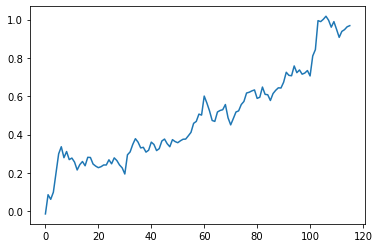

In [24]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7)} )
plt.plot(np.array(trade_loop_back.profit_array).cumsum());